# MoI ML CNN Experiment

- Train op fashion mnist
- Laat experimenten zien: kies 2 - 3 params, kies een range en voer tests uit. Doel is 93% accuracy.

In [2]:
import torch
import torch.nn as nn
import seaborn as sns
import sys
from pathlib import Path
sys.path.insert(0, "../")

In [3]:
from src.data import make_dataset
from src.models import imagemodels
from src.models import train_model
import gin


2022-12-02 23:20:46.819697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 23:20:49.901676: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-02 23:20:49.902188: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-02 23:20:49.902206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
# Load config for this notebook
gin.parse_config_file("cnn.gin")

ParsedConfigFileIncludesAndImports(filename='cnn.gin', imports=[], includes=[])

In [6]:
# Get MNIST data
train_dataloader, test_dataloader = make_dataset.get_MNIST()

In [7]:

# Set some other parameters
import torch.optim as optim
from src.models import metrics
optimizer = optim.Adam
loss_fn = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()
from src.models import train_model

## Voer een experiment uit.


### Configuratie voor het experiment

Sla de gewenste structuur voor de lagen op in een lijst configuraties

In [8]:
from dataclasses import dataclass
import itertools 
@dataclass
class NNLayerConfig:
    """Class for storing config and results for a layer."""
    accuracy: float
    num_params: int
    c1_ksize: int
    c1_stride: int
    c2_ksize: int
    c2_stride: int
    num_filters: int

configs = []  # List of NNLayerConfig objects

# Configuration for the experiment. We ignore padding for now.
# These settings take some tweaking to avoid ending up with runtime
# errors when the sizes end up too small.
kernel_sizes = [1, 2, 3]
filter_nums = [16, 32, 64]
strides = [1, 2]
# TODO it's impossible to run a truly large number of experiments
# without VSCode crashing. Let's reduce the number of permutations
# kernel_sizes = [1, 3]
# filter_nums = [16, 32]
for config in itertools.product(kernel_sizes, # kernel size in convolution 1
                                strides, # stride size in convolution 1
                                kernel_sizes, # kernel size in convolution 2
                                strides, # stride size in convolution 2
                                filter_nums, # number of filters to use
                                ):
    configs.append(NNLayerConfig(
        accuracy = 0,
        num_params = 0,
        c1_ksize = config[0],
        c1_stride = config[1],
        c2_ksize = config[2],
        c2_stride = config[3],
        num_filters = config[4],
    ))


Maak een klasse die met een configuratie als input een NN maakt.

In [9]:



# Define model
class ConfigurableNN (nn.Module):

    def __init__(self, config:NNLayerConfig, example_input):
        super().__init__()

        self.config = config
        self.maxpool_ksize = 2 # Hardcoded for now.
        # print(self.config)

        # Convolutions are set separately
        self.convolutions = nn.Sequential(
            nn.Conv2d(  1, # First one is always 1
                        self.config.num_filters, 
                        kernel_size = self.config.c1_ksize,
                        stride = self.config.c1_stride,
                        padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=self.maxpool_ksize),
            nn.Conv2d(  self.config.num_filters,
                        self.config.num_filters,
                        kernel_size = self.config.c2_ksize,
                        stride = self.config.c2_stride,
                        padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=self.maxpool_ksize)

        )

        flat_size = self.calculate_flat_size(example_input)
        
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def calculate_flat_size(self, example_input):
        current = example_input
        for conv in self.convolutions:
            current = conv(current)
        flatten = nn.Flatten()
        return flatten(current).shape[1]

    # Forward is default for now.
    def forward(self, x):
        x = self.convolutions(x)
        logits = self.dense(x)
        return logits


Loop door de configuraties heen

In [10]:
def dump_model_steps(model, example_input):
    """
    List the steps of each convolution in a model and show the result for a given input. If possible, also show what happens in a dense layer
    """
    current = example_input
    print("===============")
    print(f'Starting model with shape {current.shape}')
    print("===============")
    if(model.convolutions):
        for conv in model.convolutions:
            print("-----------------")
            print("Convolution:")
            print(conv)
            current = conv(current)
            print(current.shape)
    if(model.dense):
        print("Contents of dense:")
        for dense in model.dense:
            print("-----------------")
            print("Dense:")
            print(dense)
            current = dense(current)
            print(current.shape)


In [11]:
num_epochs = 2 # During development keep very low. 10 is for real tests
num_epochs = 10
learning_rate = 1e-3

# For to be debugging:
x, y = next(iter(train_dataloader))
x.shape, y.shape

import random # during dev
for config in configs:
    model = ConfigurableNN(config, x).to(device)
    model = train_model.trainloop(
        epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        learning_rate=learning_rate,
        loss_fn=loss_fn,
        metrics=[accuracy],
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        log_dir="../models/test/",
        train_steps=len(train_dataloader),
        eval_steps=len(test_dataloader),
    )
    config.num_params = train_model.count_parameters(model)
    yhat = model(x)
    config.accuracy = accuracy(y, yhat).item()
    # break # During development
    

2022-12-02 23:21:14.938 | INFO     | src.data.data_tools:dir_add_timestamp:114 - Logging to ../models/test/20221202-2321
100%|██████████| 1875/1875 [00:35<00:00, 53.22it/s]
2022-12-02 23:21:53.139 | INFO     | src.models.train_model:trainloop:171 - Epoch 0 train 0.6837 test 0.4845 metric ['0.8232']
100%|██████████| 1875/1875 [00:34<00:00, 55.11it/s]
2022-12-02 23:22:29.485 | INFO     | src.models.train_model:trainloop:171 - Epoch 1 train 0.4534 test 0.4428 metric ['0.8422']
100%|██████████| 1875/1875 [00:32<00:00, 57.36it/s]
2022-12-02 23:23:04.292 | INFO     | src.models.train_model:trainloop:171 - Epoch 2 train 0.4027 test 0.4091 metric ['0.8490']
100%|██████████| 1875/1875 [00:29<00:00, 64.04it/s]
2022-12-02 23:23:35.965 | INFO     | src.models.train_model:trainloop:171 - Epoch 3 train 0.3697 test 0.4128 metric ['0.8468']
100%|██████████| 1875/1875 [00:54<00:00, 34.69it/s]
2022-12-02 23:24:32.314 | INFO     | src.models.train_model:trainloop:171 - Epoch 4 train 0.3541 test 0.3788 me

Checkout results using tensorboard: 
- run `tensorboard --logdir models` in the terminal
- tensorboard will launch at `localhost:6006` and vscode will notify you that the port is forwarded
- you can either press the `launch` button in VScode or open your local browser at `localhost:6006`

## Resultaten

Voor elke configuratie hier de uiteindelijke loss en het aantal parameters.

In [1]:
import pandas as pd
import matplotlib as plt

df = pd.DataFrame(configs)
df['config_num'] = df.index
df['config_label'] = "Config: " + df["c1_ksize"].astype(str) + "/" + \
    df["c1_stride"].astype(str) + ", " + \
    df["c2_ksize"].astype(str) + "/" + \
    df["c2_stride"].astype(str) + " flt #" + \
    df["num_filters"].astype(str)
df.to_csv("output.csv", index = False)
df


NameError: name 'configs' is not defined

/tmp/ipykernel_24796/3906628986.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(rotation = 90, labels=df['config_label'])


[Text(-20.0, 0, 'Config: 1/1, 1/1 flt #16'),
 Text(0.0, 0, 'Config: 1/1, 1/1 flt #32'),
 Text(20.0, 0, 'Config: 1/1, 1/1 flt #64'),
 Text(40.0, 0, 'Config: 1/1, 1/2 flt #16'),
 Text(60.0, 0, 'Config: 1/1, 1/2 flt #32'),
 Text(80.0, 0, 'Config: 1/1, 1/2 flt #64'),
 Text(100.0, 0, 'Config: 1/1, 2/1 flt #16'),
 Text(120.0, 0, 'Config: 1/1, 2/1 flt #32')]

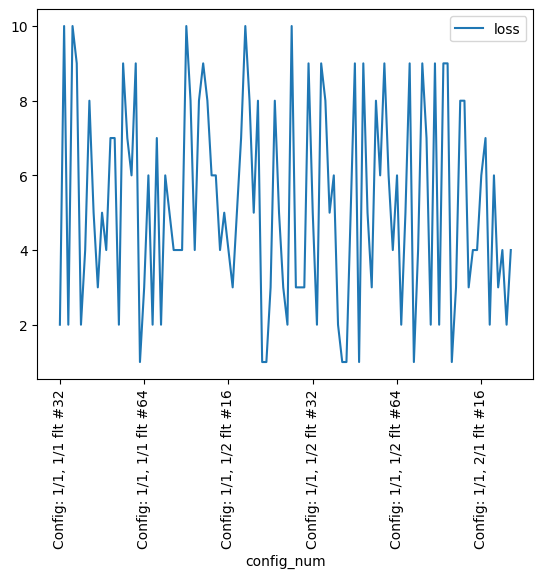

In [128]:
ax = df.plot('config_num', 'loss')
# ax.set(xticklabels= df['config_label'])
ax.set_xticklabels(rotation = 90, labels=df['config_label'])
